In [145]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import urllib.parse
import tldextract
import math
from urllib.parse import urlparse
from collections import Counter
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, label_binarize
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.patches as patches
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt 
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

In [146]:
df = pd.read_csv('./malicious_phish.csv')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [147]:
df.tail()

,url,type
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing
651190,www.angelfire.com/goth/devilmaycrytonite/,phishing


In [148]:
df.isnull().sum() # check for missing values

url     0
type    0
dtype: int64

In [149]:
summary = df.describe()
print(summary)

                                                      url    type
count                                              651191  651191
unique                                             641119       4
top     http://style.org.hc360.com/css/detail/mysite/s...  benign
freq                                                  180  428103


In [150]:
col = 'type'
freq = df[col].value_counts()
print(freq)

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64


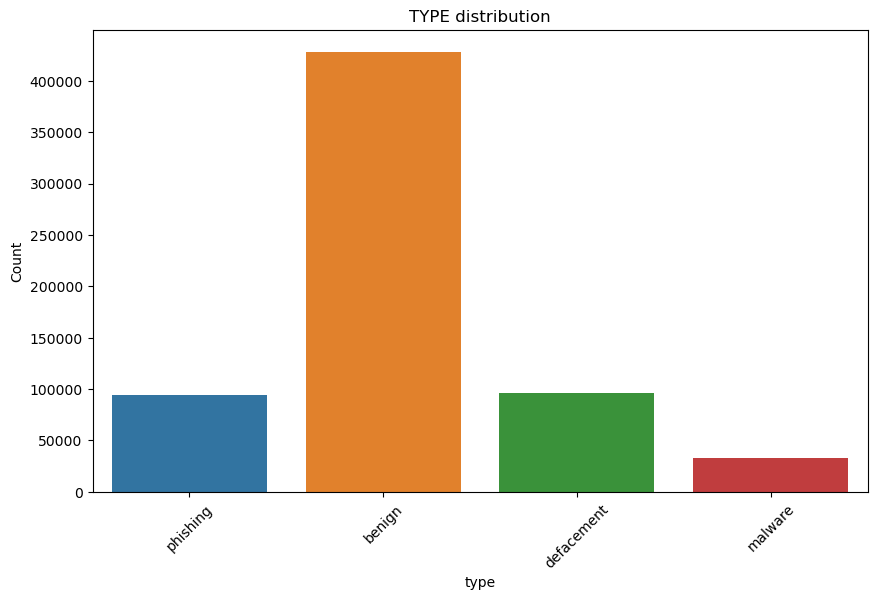

In [151]:
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df)
plt.title('TYPE distribution')
plt.xlabel(categorical_column)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [152]:
categories = ['defacement', 'malware', 'phishing']

for category in categories:
    print(f"category: {category}")
    malicious_urls = df[df['type'] == category]['url']
    print(malicious_urls)
    print('\n')

category: defacement
3         http://www.garage-pirenne.be/index.php?option=...
4         http://adventure-nicaragua.net/index.php?optio...
8              http://www.pashminaonline.com/pure-pashminas
11        http://www.ikenmijnkunst.nl/index.php/expositi...
13        http://www.lebensmittel-ueberwachung.de/index....
                                ...                        
520294    http://blueanchor.nl/dintelmarkt/page/show_cat...
520302                  http://www.hafenrocker.de/index.php
520305    http://www.kulgupuit.ee/index.php?option=com_p...
520308     http://www.nhomkinhdep.com/tu-bep-nhom-kinh.html
520325    http://www.capella.nl/nl.html?view=article&cat...
Name: url, Length: 96457, dtype: object


category: malware
38        http://www.824555.com/app/member/SportOption.p...
115       http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...
156       http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...
212       http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...
240       http://ch

In [153]:
# remove www. from urls
df['url'] = df['url'].replace('www.', '', regex=True)
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [154]:
features = pd.DataFrame()

# extract url length
features['url_length'] = df['url'].apply(len)
features.head()

,url_length
0,16
1,35
2,31
3,84
4,235


In [155]:
symbols = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
symbol_counts = {}

for s in symbols:
    count = df['url'].apply(lambda i: i.count(s)).sum()
    symbol_counts[s] = count

print(symbol_counts)

{'@': 1445, '?': 145725, '-': 1009222, '=': 393230, '.': 1305300, '#': 567, '%': 338287, '+': 44562, '$': 155, '!': 621, '*': 257, ',': 3141, '//': 190456}


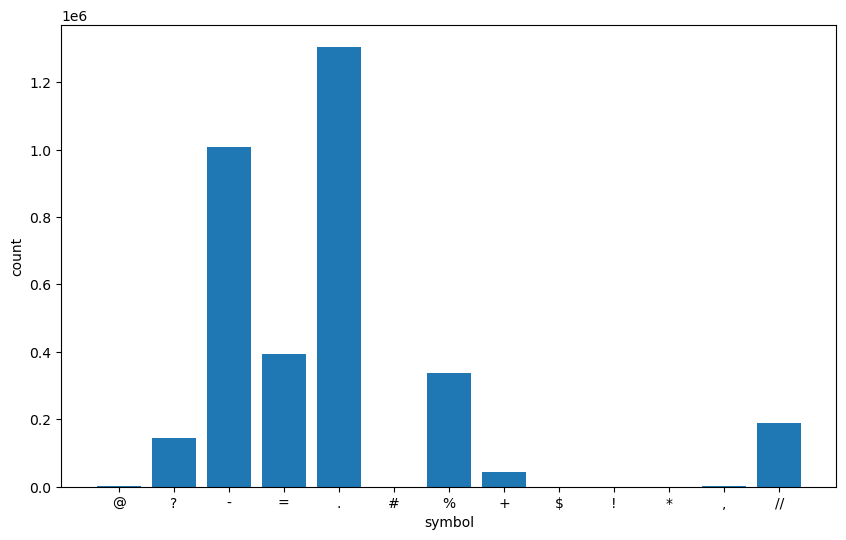

In [156]:
# visualize symbol frequency
plt.figure(figsize=(10, 6))
plt.bar(symbol_counts.keys(), symbol_counts.values())
plt.xlabel('symbol')
plt.ylabel('count')
plt.show()
# so now we know there are more hyphens and periods

In [157]:
for s in symbols:
    features[s] = df['url'].apply(lambda i: i.count(s))
features.head()

,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//
0,16,0,0,1,0,2,0,0,0,0,0,0,0,0
1,35,0,0,0,0,2,0,0,0,0,0,0,0,0
2,31,0,0,0,0,2,0,0,0,0,0,0,0,0
3,84,0,1,1,4,2,0,0,0,0,0,0,0,1
4,235,0,1,1,3,2,0,0,0,0,0,0,0,1


In [158]:
# extract domain name
features['domain'] = df['url'].apply(lambda x: tldextract.extract(x).domain)
features.head()

,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,domain
0,16,0,0,1,0,2,0,0,0,0,0,0,0,0,br-icloud
1,35,0,0,0,0,2,0,0,0,0,0,0,0,0,mp3raid
2,31,0,0,0,0,2,0,0,0,0,0,0,0,0,bopsecrets
3,84,0,1,1,4,2,0,0,0,0,0,0,0,1,garage-pirenne
4,235,0,1,1,3,2,0,0,0,0,0,0,0,1,adventure-nicaragua


In [159]:
# calculate domain entropy (how complex or random the domain name is)
def calculate_entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())
    # high entropy for more complex names

features['domain_entropy'] = features['domain'].apply(calculate_entropy)
features.head()

,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,domain,domain_entropy
0,16,0,0,1,0,2,0,0,0,0,0,0,0,0,br-icloud,3.169925
1,35,0,0,0,0,2,0,0,0,0,0,0,0,0,mp3raid,2.807355
2,31,0,0,0,0,2,0,0,0,0,0,0,0,0,bopsecrets,2.921928
3,84,0,1,1,4,2,0,0,0,0,0,0,0,1,garage-pirenne,2.896292
4,235,0,1,1,3,2,0,0,0,0,0,0,0,1,adventure-nicaragua,3.405822


/var/folders/j8/p6jt6dwx4rd8pt_c8kxpd7r00000gn/T/ipykernel_26508/3483163319.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(features['domain_entropy'], shade=True)


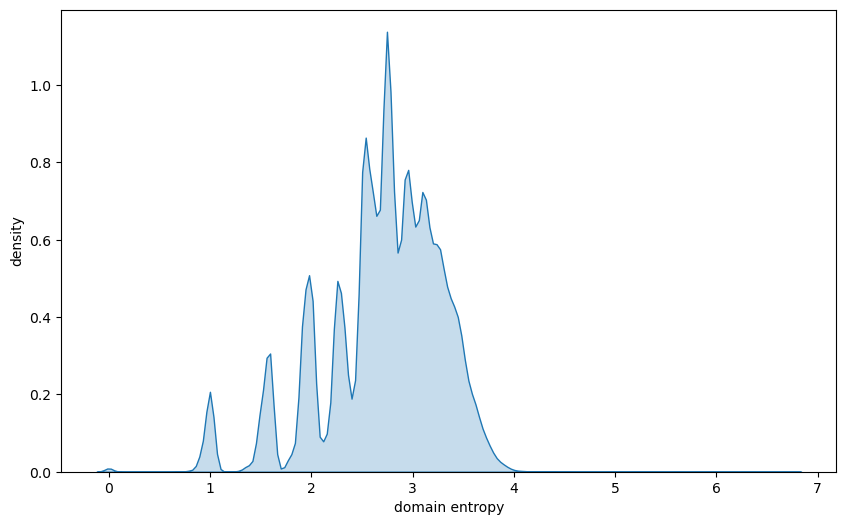

In [163]:
# visualize domain entropy
plt.figure(figsize=(10, 6))
sns.kdeplot(features['domain_entropy'], shade=True)
plt.xlabel('domain entropy')
plt.ylabel('density')
plt.show()

In [168]:
# extract type of top-level domain
features['tld'] = df['url'].apply(lambda x: int(tldextract.extract(x).suffix in ['info', 'tk']))
features.head()

,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,domain,domain_entropy,TLD,tld
0,16,0,0,1,0,2,0,0,0,0,0,0,0,0,br-icloud,3.169925,0,0
1,35,0,0,0,0,2,0,0,0,0,0,0,0,0,mp3raid,2.807355,0,0
2,31,0,0,0,0,2,0,0,0,0,0,0,0,0,bopsecrets,2.921928,0,0
3,84,0,1,1,4,2,0,0,0,0,0,0,0,1,garage-pirenne,2.896292,0,0
4,235,0,1,1,3,2,0,0,0,0,0,0,0,1,adventure-nicaragua,3.405822,0,0


In [167]:
features['tld'] = df['url'].apply(lambda x: tldextract.extract(x).suffix)
print(features[features['tld'] != ''])

        url_length  @  ?  -  =  .  #  %  +  $  !  *  ,  //  \
0               16  0  0  1  0  2  0  0  0  0  0  0  0   0   
1               35  0  0  0  0  2  0  0  0  0  0  0  0   0   
2               31  0  0  0  0  2  0  0  0  0  0  0  0   0   
3               84  0  1  1  4  2  0  0  0  0  0  0  0   1   
4              235  0  1  1  3  2  0  0  0  0  0  0  0   1   
...            ... .. .. .. .. .. .. .. .. .. .. .. ..  ..   
651186          39  0  0  0  0  3  0  0  0  0  0  0  0   0   
651187          44  0  0  2  0  2  0  0  0  0  0  0  0   0   
651188          38  0  0  0  0  1  0  0  0  0  0  0  0   0   
651189          45  0  0  0  0  2  0  0  0  0  0  0  0   0   
651190          37  0  0  0  0  1  0  0  0  0  0  0  0   0   

                     domain  domain_entropy  TLD     tld  
0                 br-icloud        3.169925    0  com.br  
1                   mp3raid        2.807355    0     com  
2                bopsecrets        2.921928    0     org  
3            garage